# Домашнее задание 7 (20 pts)

Рассмотрим классическую модель для построения рекомендательных систем, основанную на матричной факторизации матрицы "item-user" $A$, которая содержит известные рейтинги продуктов от пользователей: 

$$ \min_{P, Q} \sum_{(i, u) \in \mathcal{A}} (a_{ui} - \langle p_u, q_i \rangle)^2 + \frac{\lambda}{2}\left(\|P\|_F^2 + \|Q\|_F^2\right), \quad \lambda > 0, $$

где $\mathcal{A}$ множество пар пользователей и продуктов, рейтинги которых известны, а матрицы $P \in \mathbb{R}^{M \times d}$ и $Q \in \mathbb{R}^{N \times d}$ содержат вложения пользователей и продуктов в $d$-мерное пространство. Зафиксируйте $d$ достаточно большим для получения приемлемого качества, но учтите затраты по памяти.
Вам предлагается проанализировать эффективность различных методов решения этой задачи для данных с рейтингами книг, скачать которые можно [отсюда](https://www.kaggle.com/datasets/arashnic/book-recommendation-dataset?select=Ratings.csv).
Для отслеживания эффекта переобучения разделите пользователей и продукты на обучающую и тестовую выборку. Способ разбиения остаётся на ваше усмотрение. Главное, чтобы он был разумен и отражал основную цель.

Для оценки эффективности можно использовать следующие метрики:
1) значение целевой функции на обучающей и тестовой выборке

2) precision@k для небольшого $k$ по аналогии с задачей классификации

- Индекс рекомендуемого продукта генерируется сортировкой оценок релевантности $Qp_u$ для пользователя с индексом $u$ и исключением уже оценённых продуктов.
- Обратите внимание, что матрица $A$ разрежена и требует аккуратного обращения со своими элементами, чтобы не столкнуться с нехваткой памяти. Особенно это касается процедуры вычисления градиентов. Не забывайте об эффективности приводимых реализаций! 

Поскольку целевая функция представляет из себя сумму функций каждая из которых зависит от своего индекса, то имеет смысл попробовать использовать стохатическую оценку градиента в методах первого порядка. Однако задача не является выпуклой, поэтому можно по-разному обновлять параметры $P$ и $Q$. Например, сравните, какая из следующих стратегий лучше
1) $P$ и $Q$ объединяются в один длинный вектор и обновляются одновренно одним из методов

2) попеременная оптимизация $P$ и $Q$ каким-то градиентным методов, то есть $P$ фиксирована и обновляется $Q$ сколько-то итераций, возможно до сходимости, и далее наоборот обновляется $P$ при фиксированной новой $Q$ с предыдущей итерации.

Сравните методы SGD, SGD Momentum, Adam и [Adan](https://github.com/sail-sg/Adan).

Возможно, для разных стратегий будет лучше работать разные методы. Приведите графики сходимости и обсуждение полученных результатов.

In [1]:
import numpy as np
import torch
import pandas as pd
from IPython.display import display, HTML
# import scipy.sparse as ss
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

# Предобработка

In [3]:
ratings_df = pd.read_csv('archive/Ratings.csv')
display(ratings_df.head())

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


Оставим одинаковые наборы книг и пользователей.  
Для трейна и теста разобьем проставленные оценки.  
Добавим 1 к рейтингу, чтобы можно было отличать 0 от непроставленной оценки

In [4]:
ratings_df['rating'] = ratings_df['Book-Rating'] + 1

compress_user_id = {user: i for i, user in enumerate(ratings_df['User-ID'].unique())}
compress_isbn = {isbn: i for i, isbn in enumerate(ratings_df['ISBN'].unique())}

ratings_df['user'] = ratings_df['User-ID'].apply(lambda x: compress_user_id[x])
ratings_df['book'] = ratings_df['ISBN'].apply(lambda x: compress_isbn[x])

n_users = len(compress_user_id)
n_books = len(compress_isbn)

print(f'number of users {n_users} number of books {n_books}')
ratings_df.head()

number of users 105283 number of books 340556


,User-ID,ISBN,Book-Rating,rating,user,book
0,276725,034545104X,0,1,0,0
1,276726,0155061224,5,6,1,1
2,276727,0446520802,0,1,2,2
3,276729,052165615X,3,4,3,3
4,276729,0521795028,6,7,3,4


In [5]:
ratings_train, ratings_test = train_test_split(ratings_df, test_size=0.3)

In [6]:
ratings_train_ss = torch.sparse_coo_tensor(
    torch.tensor(ratings_train[['user', 'book']].values.T),
    torch.tensor(ratings_train['rating'].values), 
    [n_users, n_books]
).coalesce()

ratings_test_ss = torch.sparse_coo_tensor(
    torch.tensor(ratings_test[['user', 'book']].values.T),
    torch.tensor(ratings_test['rating'].values), 
    [n_users, n_books]
).coalesce()

# Обучение

In [7]:
def loss_func(values, predictions, P, Q, lam):
    return lam * (torch.norm(P) + torch.norm(Q)) + ((values - predictions)**2).sum()

In [8]:
class MyModel(torch.nn.Module):
    def __init__(self, d, n_users, n_books):
        super().__init__()
        P = torch.ones((n_users, d), requires_grad=True)
        Q = torch.ones((n_books, d), requires_grad=True) * np.mean(ratings_test['rating']) / d

        self.linears = torch.nn.ParameterList([P, Q])

    def forward(self, rows, columns):
        P, Q = self.linears
        return (P[rows] * Q[columns]).sum(axis=1)

In [23]:
lam = 0
d = 10

  0%|          | 0/100 [00:00<?, ?it/s]

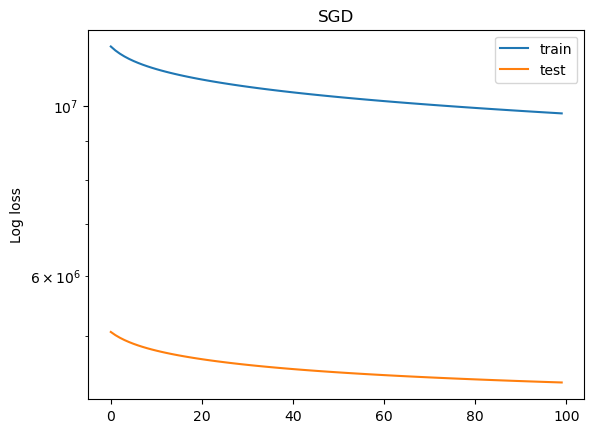

In [24]:
net = MyModel(d, n_users, n_books)
optim = torch.optim.SGD(net.parameters(), lr=1e-5, momentum=0)

indices = ratings_train_ss.indices().T
rows = indices[:, 0]
columns = indices[:, 1]
values = ratings_train_ss.values()

indices = ratings_test_ss.indices().T
rows_test = indices[:, 0]
columns_test = indices[:, 1]
values_test = ratings_test_ss.values()

train_loss = []
test_loss = []


for _ in tqdm(range(100)):
    predictions = net(rows, columns)
    P, Q = net.parameters()
    loss = loss_func(values, predictions, P, Q, lam)

    optim.zero_grad()
    loss.backward()
    optim.step()

    train_loss.append(loss.item())

    with torch.no_grad():
        predictions = net(rows_test, columns_test)
        P, Q = net.parameters()
        loss = loss_func(values_test, predictions, P, Q, lam)
        test_loss.append(loss.item())

plt.plot(list(range(len(train_loss))), train_loss, label='train')
plt.plot(list(range(len(test_loss))), test_loss, label='test')
plt.title('SGD')
plt.legend()
plt.yscale('log')
plt.ylabel('Log loss')
plt.show()

Все с `lr > 1e-5` у меня начинает расходиться.  
А с такими параметрами сходится очень очень медленно.  
Ошибка на тесте почти так же уменьшается как и на трейне, 
особенно если учесть что лосс зависит от размера выборки.  

  0%|          | 0/1000 [00:00<?, ?it/s]

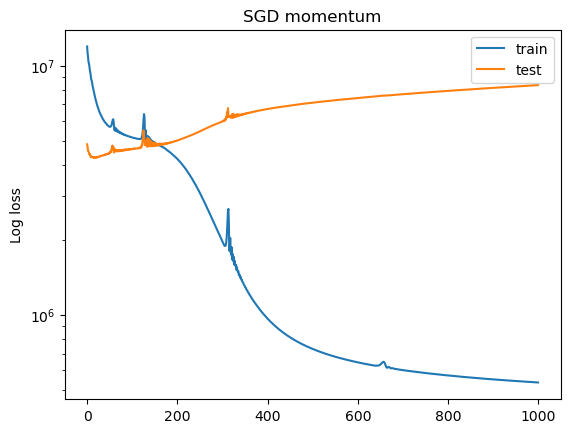

In [25]:
net = MyModel(d, n_users, n_books)
optim = torch.optim.SGD(net.parameters(), lr=1e-4, momentum=0.9)

indices = ratings_train_ss.indices().T
rows = indices[:, 0]
columns = indices[:, 1]
values = ratings_train_ss.values()

indices = ratings_test_ss.indices().T
rows_test = indices[:, 0]
columns_test = indices[:, 1]
values_test = ratings_test_ss.values()

train_loss = []
test_loss = []


for _ in tqdm(range(1000)):
    predictions = net(rows, columns)
    P, Q = net.parameters()
    loss = loss_func(values, predictions, P, Q, lam)

    optim.zero_grad()
    loss.backward()
    optim.step()

    train_loss.append(loss.item())

    with torch.no_grad():
        predictions = net(rows_test, columns_test)
        P, Q = net.parameters()
        loss = loss_func(values_test, predictions, P, Q, lam)
        test_loss.append(loss.item())

plt.plot(list(range(len(train_loss))), train_loss, label='train')
plt.plot(list(range(len(test_loss))), test_loss, label='test')
plt.title('SGD momentum')
plt.legend()
plt.yscale('log')
plt.ylabel('Log loss')
plt.show()

Лосс на трейне неплохо падает.  
Однако по всей видимости модель сильно переобучается и ошибка на тесте с количеством эпох так же растет.  
Можно попробовать поменять параметры модели - увеличить штраф за веса и поменять размерность.

  0%|          | 0/100 [00:00<?, ?it/s]

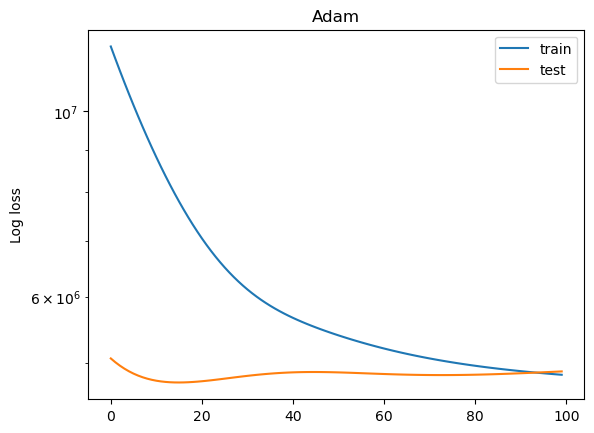

In [26]:
net = MyModel(d, n_users, n_books)
optim = torch.optim.Adam(net.parameters(), lr=0.01)

indices = ratings_train_ss.indices().T
rows = indices[:, 0]
columns = indices[:, 1]
values = ratings_train_ss.values()

indices = ratings_test_ss.indices().T
rows_test = indices[:, 0]
columns_test = indices[:, 1]
values_test = ratings_test_ss.values()

train_loss = []
test_loss = []

for _ in tqdm(range(100)):
    predictions = net(rows, columns)
    P, Q = net.parameters()
    loss = loss_func(values, predictions, P, Q, lam)

    optim.zero_grad()
    loss.backward()
    optim.step()

    train_loss.append(loss.item())

    with torch.no_grad():
        predictions = net(rows_test, columns_test)
        P, Q = net.parameters()
        loss = loss_func(values_test, predictions, P, Q, lam)
        test_loss.append(loss.item())

plt.plot(list(range(len(train_loss))), train_loss, label='train')
plt.plot(list(range(len(test_loss))), test_loss, label='test')
plt.title('Adam')
plt.legend()
plt.yscale('log')
plt.ylabel('Log loss')
plt.show()

Стоит заметить, что тут уже подходит сильно бОльший `lr`  
Картинка напоминает на `svd_momentum` но сильно быстрее и плавнее.  
+1 к тому что выбраны неудачные параметры модели.

In [27]:
!pip install adan-pytorch

In [28]:
from adan_pytorch import Adan

  0%|          | 0/1000 [00:00<?, ?it/s]

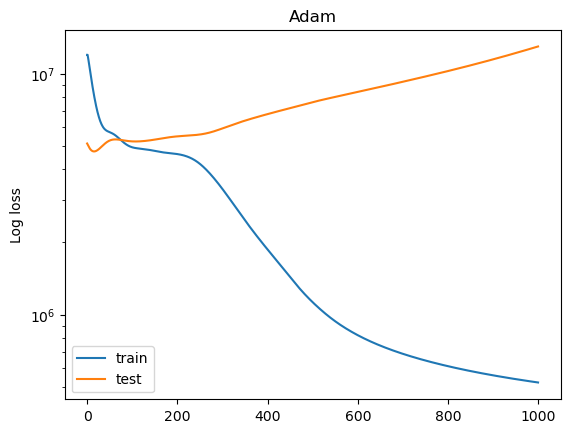

In [30]:
net = MyModel(d, n_users, n_books)
optim = Adan(net.parameters(), lr=0.01)

indices = ratings_train_ss.indices().T
rows = indices[:, 0]
columns = indices[:, 1]
values = ratings_train_ss.values()

indices = ratings_test_ss.indices().T
rows_test = indices[:, 0]
columns_test = indices[:, 1]
values_test = ratings_test_ss.values()

train_loss = []
test_loss = []

for _ in tqdm(range(1000)):
    predictions = net(rows, columns)
    P, Q = net.parameters()
    loss = loss_func(values, predictions, P, Q, lam)

    optim.zero_grad()
    loss.backward()
    optim.step()

    train_loss.append(loss.item())

    with torch.no_grad():
        predictions = net(rows_test, columns_test)
        P, Q = net.parameters()
        loss = loss_func(values_test, predictions, P, Q, lam)
        test_loss.append(loss.item())

plt.plot(list(range(len(train_loss))), train_loss, label='train')
plt.plot(list(range(len(test_loss))), test_loss, label='test')
plt.title('Adam')
plt.legend()
plt.yscale('log')
plt.ylabel('Log loss')
plt.show()

Почти тоже самое что и `adam`.  
Разницы почти нет.